In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

In [2]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

In [3]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')



def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

In [4]:
df = sns.load_dataset('titanic').drop(['alive'],axis=1)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(4)
memory usage: 73.7+ KB


In [6]:
for col in df.select_dtypes(include='category'):
  df[col] = df[col].astype('object')

In [7]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alone            0
dtype: int64

In [8]:
from feature_engine.imputation import MeanMedianImputer

In [9]:
variables_method = ['age']
variables_method

['age']

In [10]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['age'] 




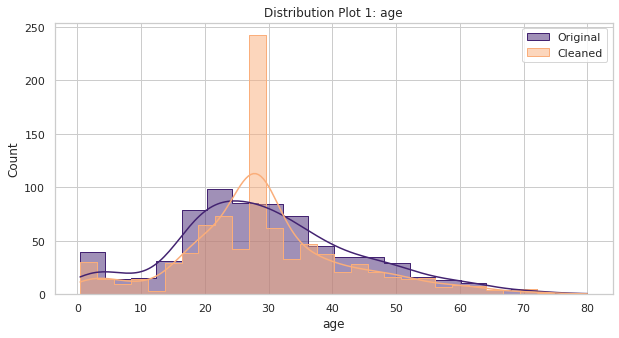

In [11]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [12]:
from feature_engine.imputation import CategoricalImputer

In [13]:
variables_method = ['embarked', 'deck', 'embark_town']
variables_method

['embarked', 'deck', 'embark_town']

In [14]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing',
                             variables=variables_method)

df_method = imputer.fit_transform(df)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['embarked', 'deck', 'embark_town'] 




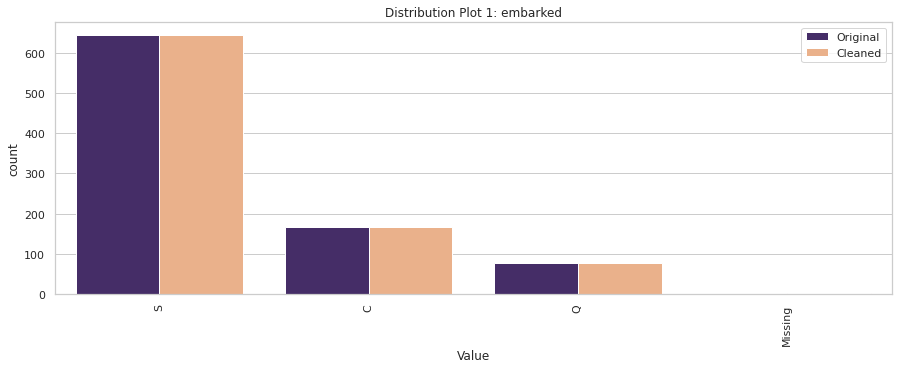

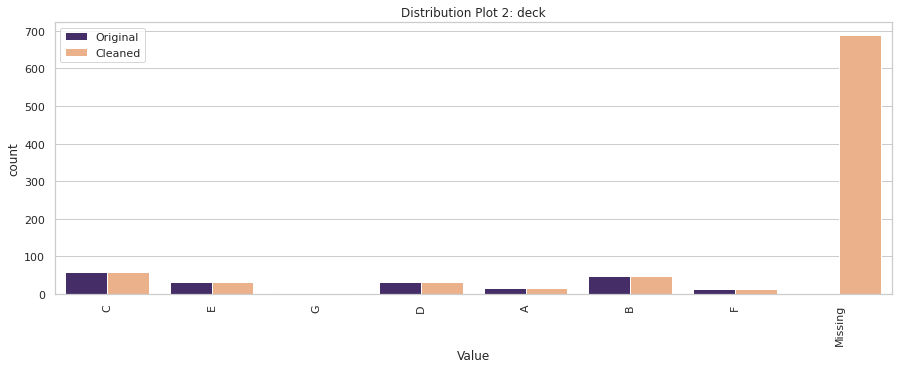

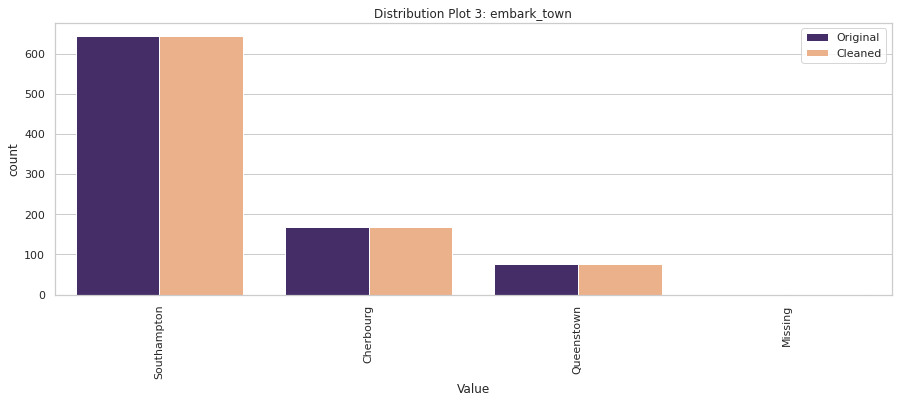

In [15]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [16]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [17]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alone            0
dtype: int64

In [19]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import DropMissingData

data_cleaning_pipeline = Pipeline([
      ( 'DropFeatures', DropFeatures(features_to_drop=['deck']) ),
      ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=['age']) ),
      ( 'DropMissingData', DropMissingData()),
])

df = data_cleaning_pipeline.fit_transform(df)

In [20]:
df.isna().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alone          0
dtype: int64

In [21]:
variables_engineering= ['sex', 'embarked', 'who', 'embark_town']
variables_engineering

['sex', 'embarked', 'who', 'embark_town']

In [22]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,sex,embarked,who,embark_town
0,male,S,man,Southampton
1,female,C,woman,Cherbourg
2,female,S,woman,Southampton


* Variable Analyzed: sex
* Applied transformation: ['sex_ordinal_encoder'] 



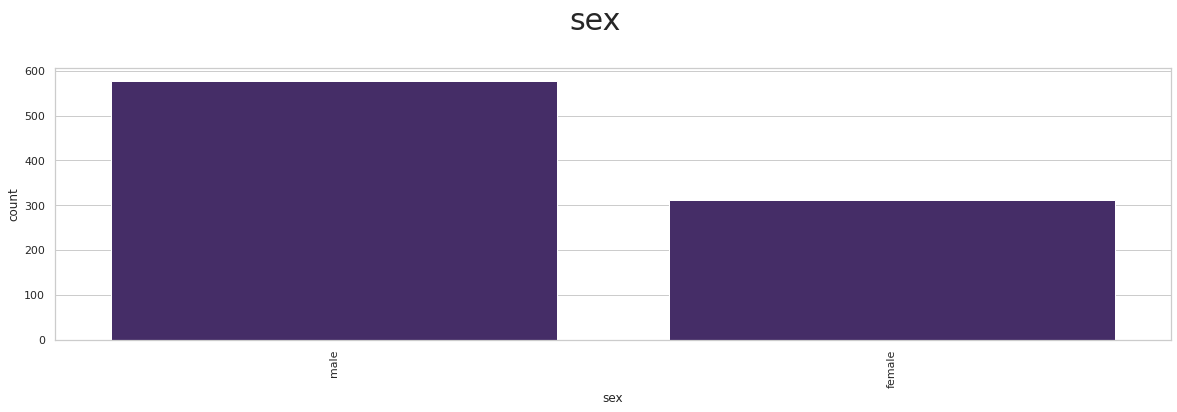

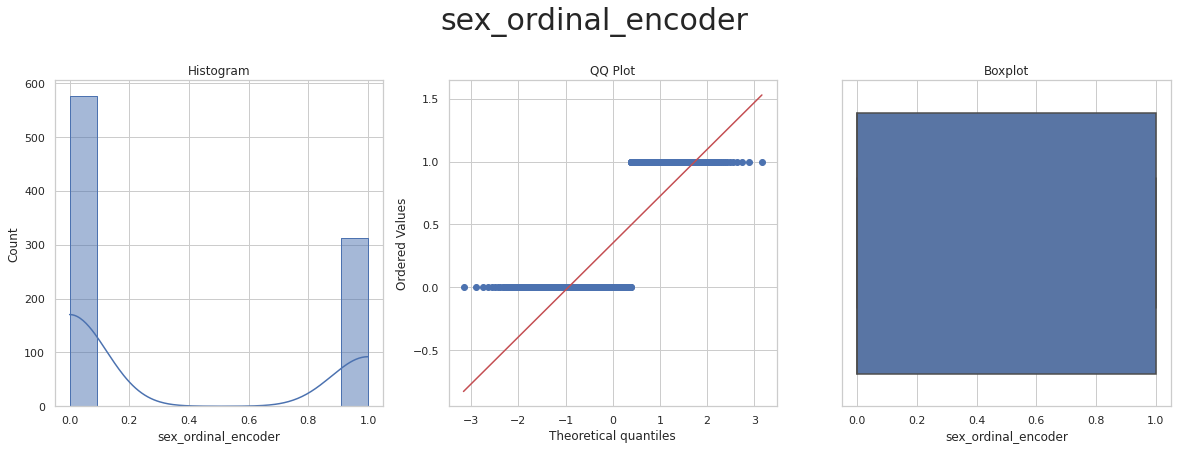



* Variable Analyzed: embarked
* Applied transformation: ['embarked_ordinal_encoder'] 



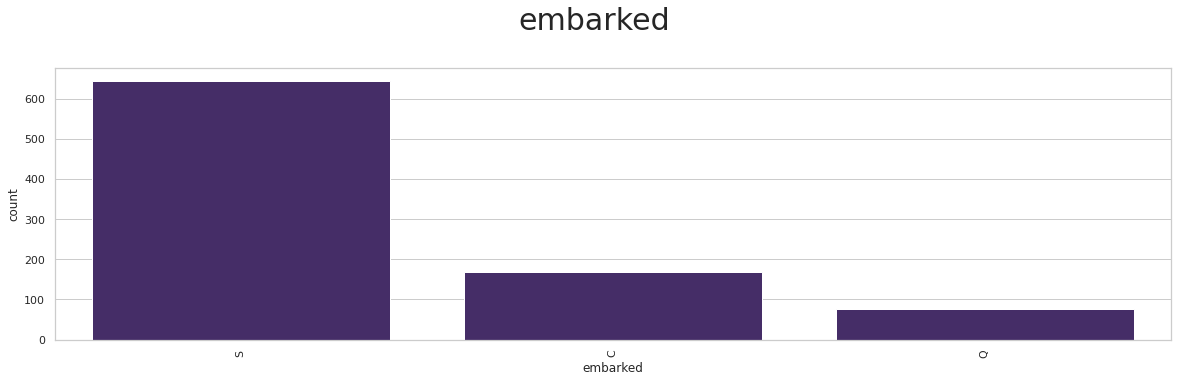

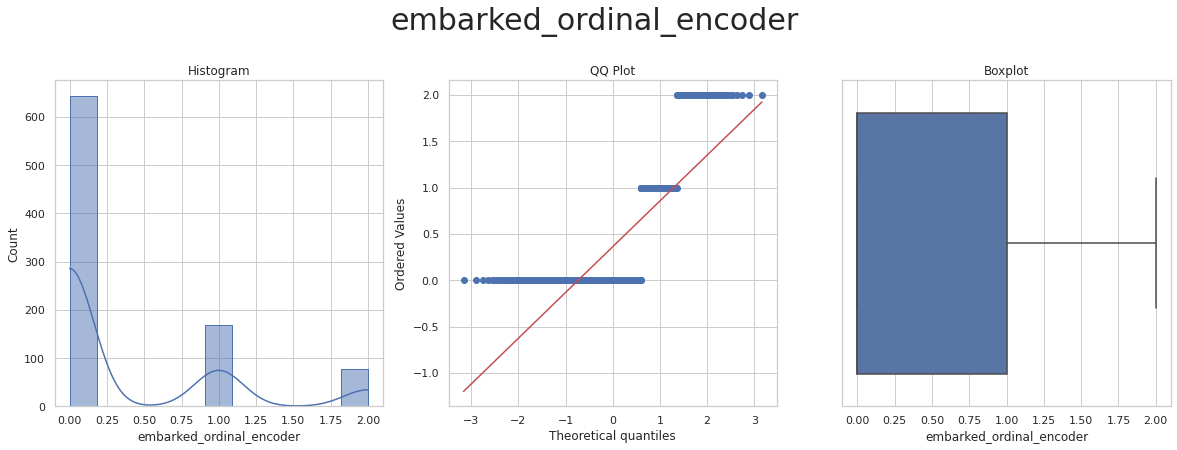



* Variable Analyzed: who
* Applied transformation: ['who_ordinal_encoder'] 



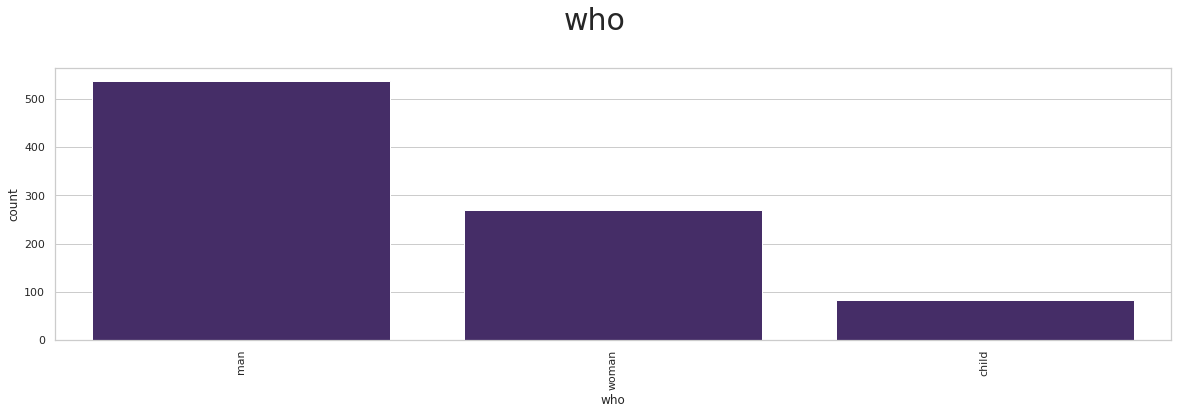

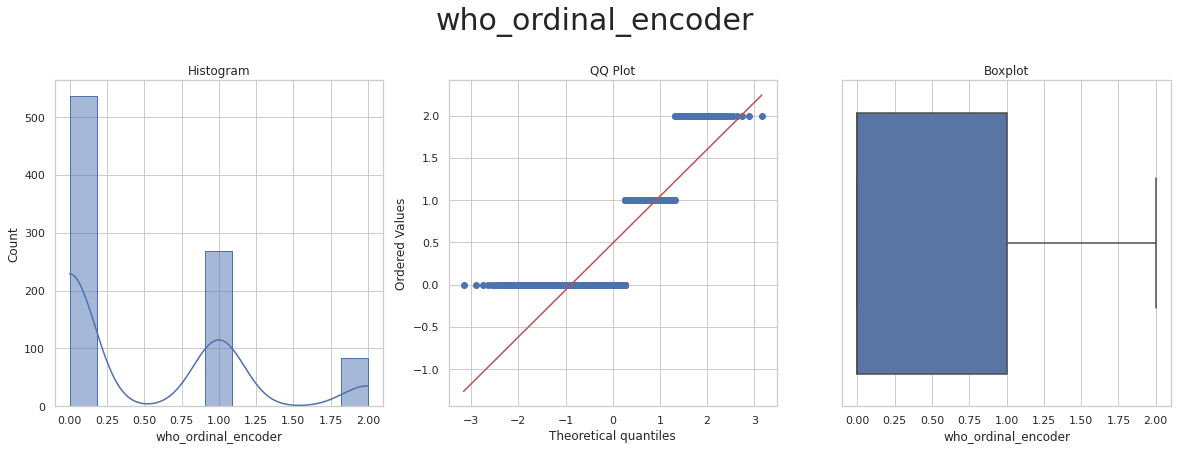



* Variable Analyzed: embark_town
* Applied transformation: ['embark_town_ordinal_encoder'] 



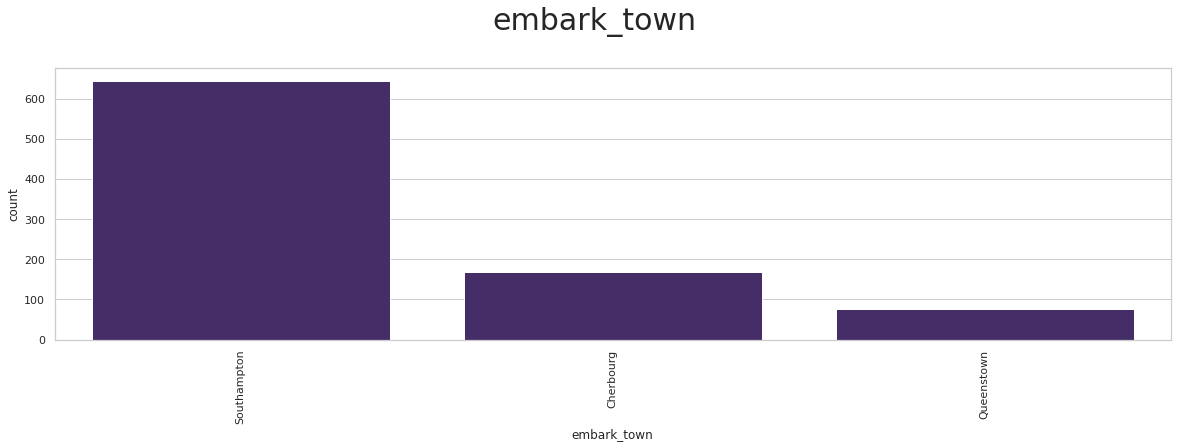

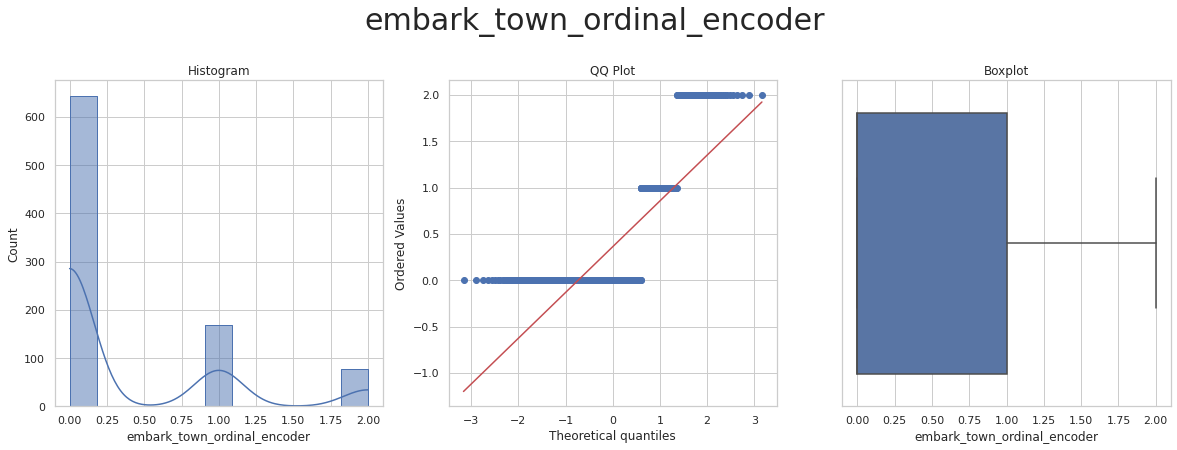

In [23]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,analysis_type='ordinal_encoder')

In [24]:
variables_engineering = ['age', 'fare']
variables_engineering

['age', 'fare']

In [25]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250


* Variable Analyzed: age
* Applied transformation: ['age_iqr'] 



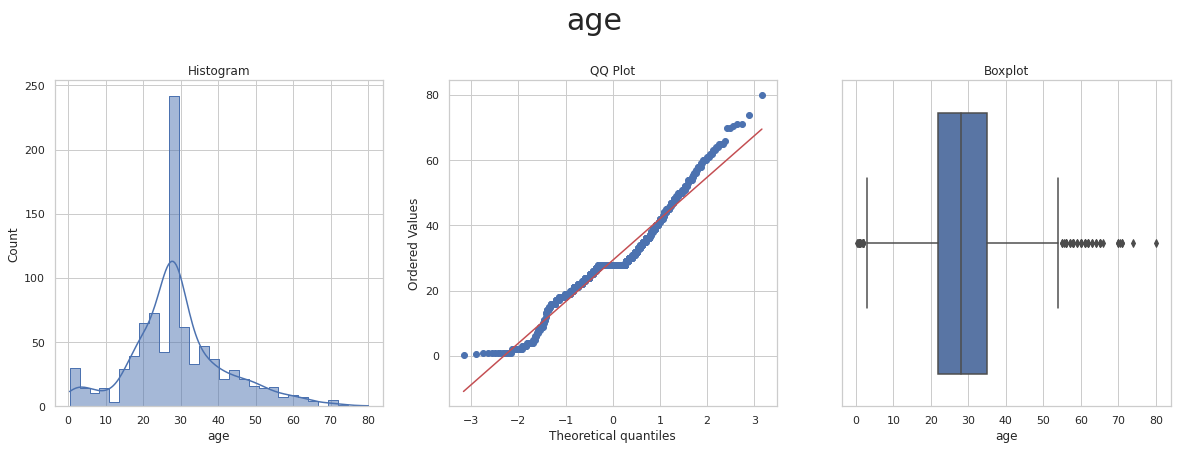

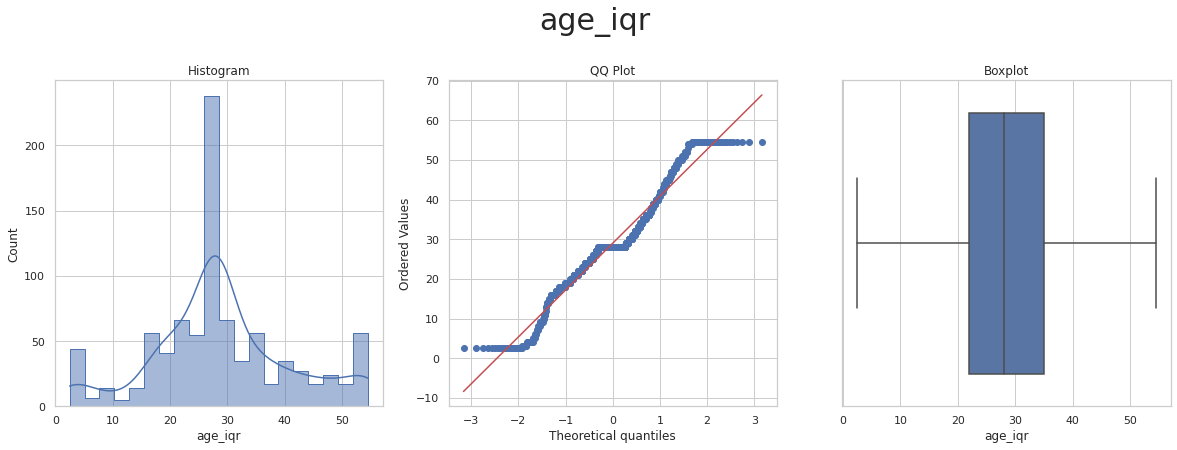



* Variable Analyzed: fare
* Applied transformation: ['fare_iqr'] 



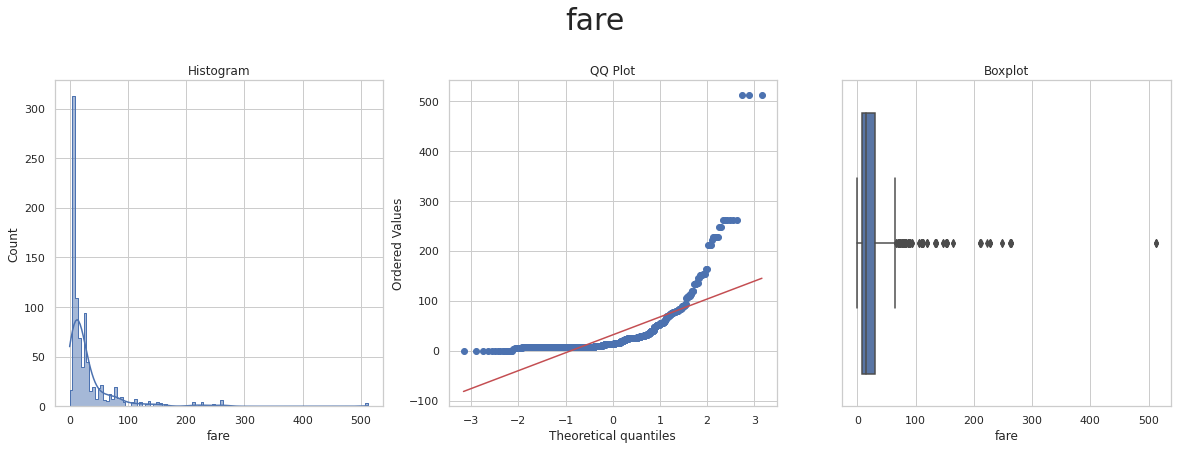

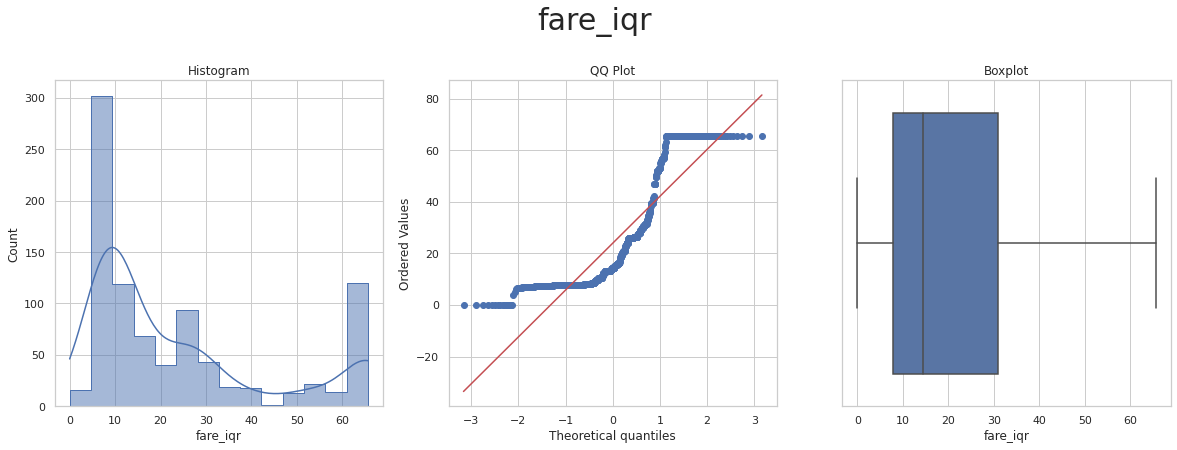

In [26]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),
                                            analysis_type='outlier_winsorizer')

In [27]:
variables_engineering= ['fare']
variables_engineering

['fare']

In [28]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,fare
0,7.2500
1,71.2833
2,7.9250


* Variable Analyzed: fare
* Applied transformation: ['fare_power', 'fare_yeo_johnson'] 



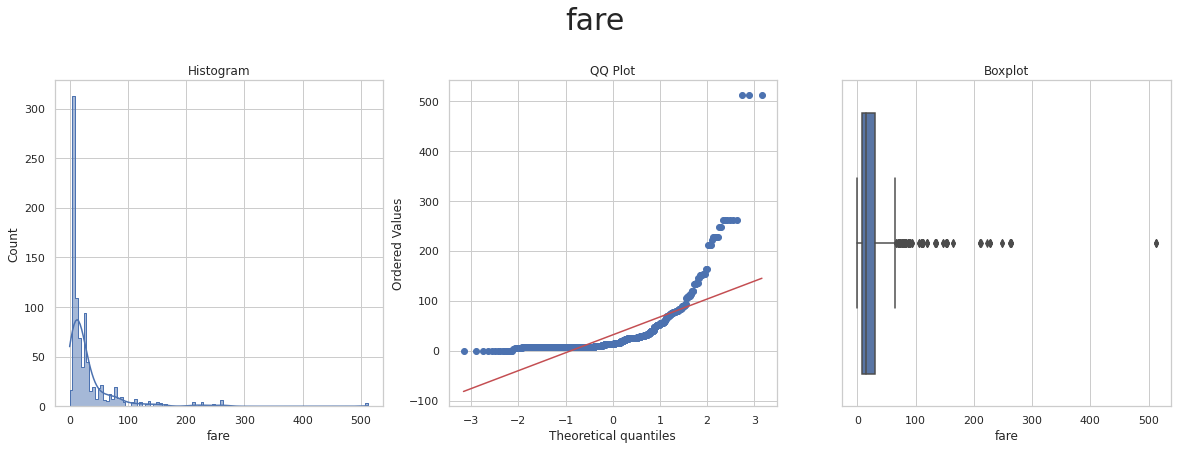

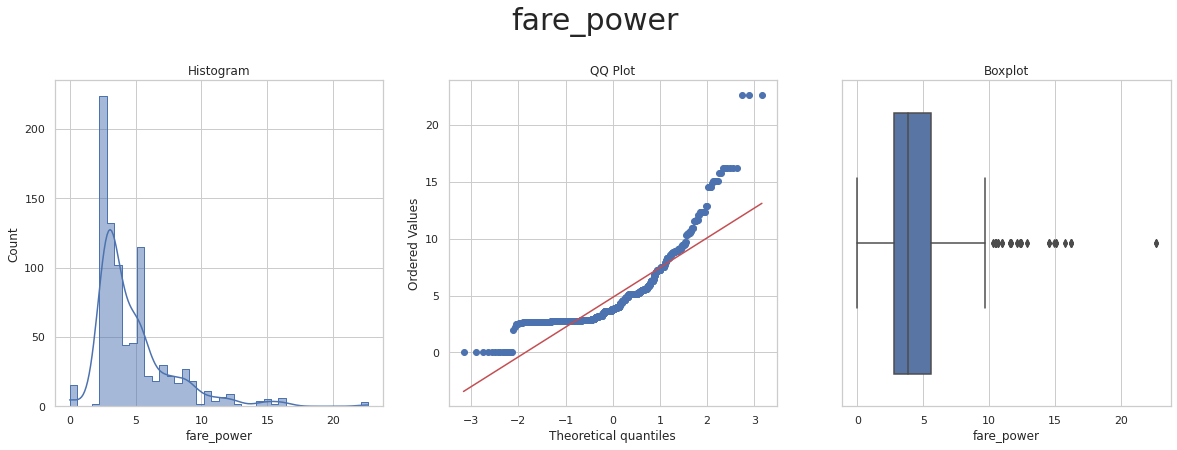

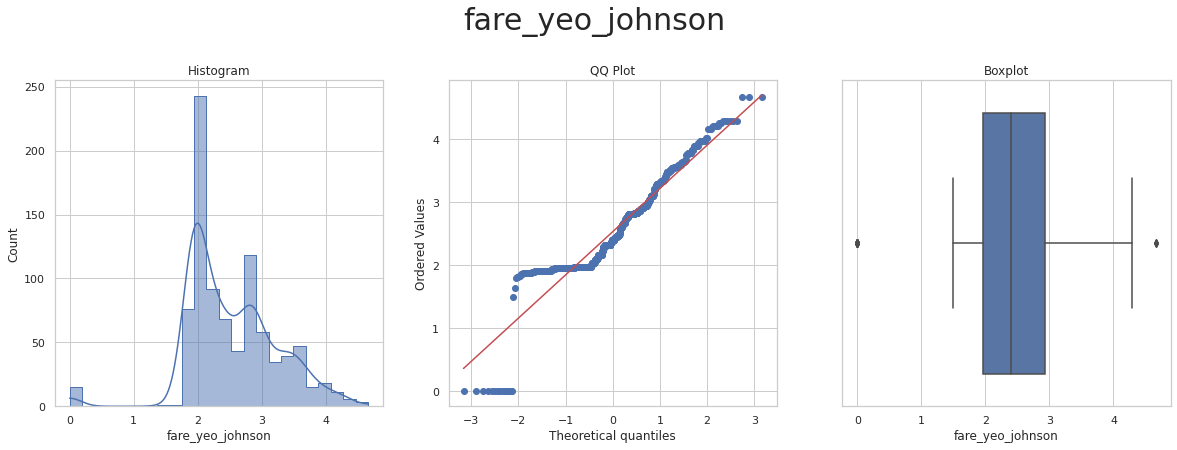

In [29]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,analysis_type='numerical')